In [1]:
import pandas as pd
import warnings
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
import itertools
warnings.filterwarnings("ignore")

In [2]:
# Loading the data and checking if it is correctly loaded
df = pd.read_excel('MER_T12_06.xlsx')
df.head(10)

,MSN,YYYYMM,Value,Description
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions
5,CLEIEUS,197306,66.538,Coal Electric Power Sector CO2 Emissions
6,CLEIEUS,197307,72.626,Coal Electric Power Sector CO2 Emissions
7,CLEIEUS,197308,75.181,Coal Electric Power Sector CO2 Emissions
8,CLEIEUS,197309,68.397,Coal Electric Power Sector CO2 Emissions
9,CLEIEUS,197310,67.668,Coal Electric Power Sector CO2 Emissions


In [3]:
#Adding date column and checking the null rows
df['Date'] = df['YYYYMM'].apply(lambda x: pd.to_datetime(x, format = '%Y%m', errors ='coerce'))
df[df['Date'].isna()]['YYYYMM'].drop_duplicates().reset_index(drop = True).to_frame().T

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
YYYYMM,197313,197413,197513,197613,197713,197813,197913,198013,198113,198213,...,200613,200713,200813,200913,201013,201113,201213,201313,201413,201513


- We can see that all rows that have null 'Date' values are there because of rows with month 13. Although it is possible these rows were intentionally put in there for a purpose, it is not needed for our analysis so can safely remove them from our dataset


In [4]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4707 entries, 0 to 5093
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   MSN          4707 non-null   object        
 1   YYYYMM       4707 non-null   int64         
 2   Value        4707 non-null   object        
 3   Description  4707 non-null   object        
 4   Date         4707 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 220.6+ KB


In [5]:
#Transforming 'Value' column to float data type and checking the null values
df['Value_num'] = pd.to_numeric(df["Value"], errors = 'coerce')
df[df['Value_num'].isna()]

,MSN,YYYYMM,Value,Description,Date,Value_num
3396,GEEIEUS,197301,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-01-01,NaN
3397,GEEIEUS,197302,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-02-01,NaN
3398,GEEIEUS,197303,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-03-01,NaN
3399,GEEIEUS,197304,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-04-01,NaN
3400,GEEIEUS,197305,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-05-01,NaN
...,...,...,...,...,...,...
4164,NWEIEUS,198808,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-08-01,NaN
4165,NWEIEUS,198809,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-09-01,NaN
4166,NWEIEUS,198810,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-10-01,NaN
4167,NWEIEUS,198811,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-11-01,NaN


In [6]:
df['Value_num'] = df["Value_num"].fillna(0)

In [7]:
# Transforming and simplifying data for visualization and analysis
t = df['Description'].drop_duplicates().reset_index(drop = True)
t

0             Coal Electric Power Sector CO2 Emissions
1      Natural Gas Electric Power Sector CO2 Emissions
2    Distillate Fuel, Including Kerosene-Type Jet F...
3    Petroleum Coke Electric Power Sector CO2 Emiss...
4    Residual Fuel Oil Electric Power Sector CO2 Em...
5        Petroleum Electric Power Sector CO2 Emissions
6    Geothermal Energy Electric Power Sector CO2 Em...
7    Non-Biomass Waste Electric Power Sector CO2 Em...
8     Total Energy Electric Power Sector CO2 Emissions
Name: Description, dtype: object

In [9]:
#Creating 'Fuel Type' column with simplified description
dic ={}
dic[t[0]] = 'Coal'
dic[t[1]] = 'Natural Gas'
dic[t[2]] = 'Distillate Fuel'
dic[t[3]] = 'Petroleum Coke'
dic[t[4]] = 'Residual Fuel Oil'
dic[t[5]] = 'Petroleum'
dic[t[6]] = 'Geothermal Energy'
dic[t[7]] = 'Non Biomass Waste'
dic[t[8]] = 'Total'

df['Fuel Type'] = df['Description'].apply(lambda x: dic[x])

Text(0.5, 1.0, 'Monthly CO2 Emission by Fuel Type')

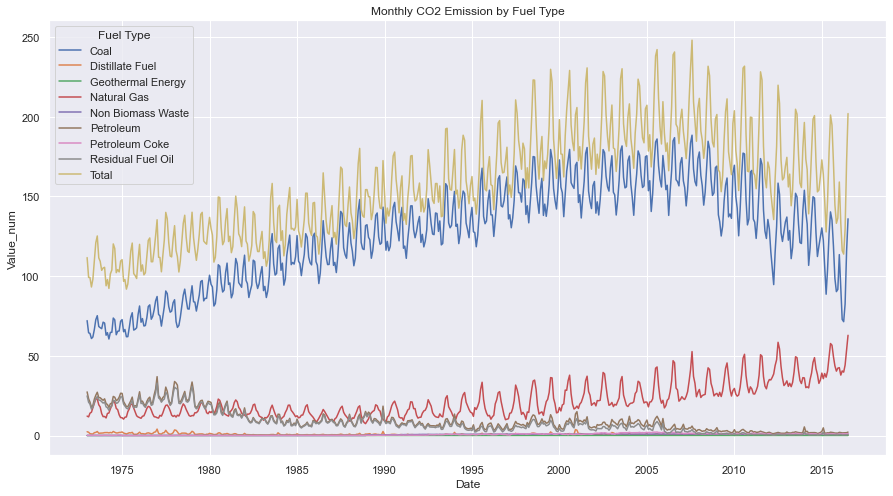

In [10]:
dfg = df.groupby(['Date', 'Fuel Type'])['Value_num'].sum().reset_index()
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=dfg, x="Date", y="Value_num", hue="Fuel Type").set_title("Monthly CO2 Emission by Fuel Type")

**Observation**

- Although we can see general trend from above plot, there does seem to be seasonality within 1 year period. To get better better visualization that better show overall trend, let's try to plot moving average instead.

Text(0.5, 1.0, '12 Month Moving Average of Monthly CO2 Emission by Fuel Type')

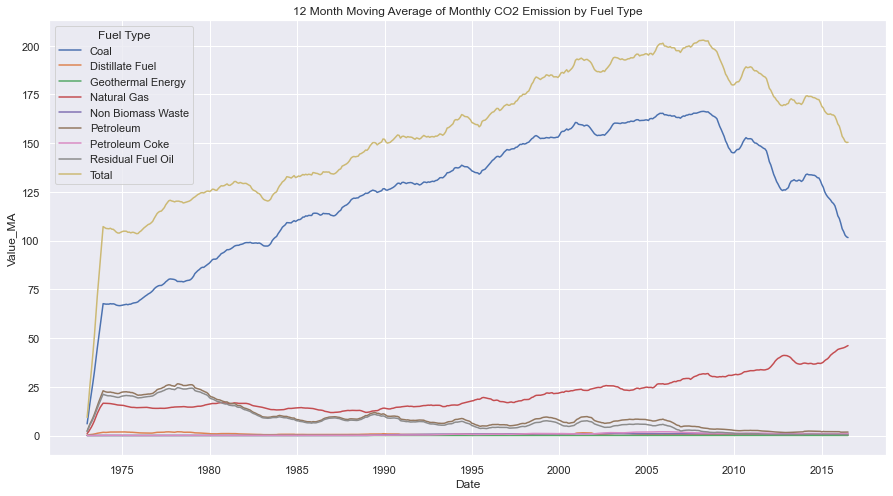

In [11]:
#Function to return 12 month moving Average
def MA_value(df,x):
    return df[(df['Date'] > x["Date"] - dt.timedelta(days = 365)) & (df['Date'] <= x["Date"]) & (df['Fuel Type'] == x['Fuel Type'])]['Value_num'].sum() / 12

dfg['Value_MA'] = dfg.apply(lambda x: MA_value(dfg,x), axis = 1)
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=dfg, x="Date", y="Value_MA", hue="Fuel Type").set_title("12 Month Moving Average of Monthly CO2 Emission by Fuel Type")

**Observation**

- CO2 emissions from fuel sources other than Nautral gas and coal have become rather irrelavent since the mid 2000's. For the convenience of our analysis, and since our interest is in the future, I will lump 'Distillate Fuel', 'Petroleum', "Petroleum coke" and "Residual Fuel Oil" together as "Crude Oil" and "Geothermal Energy" as "Renewable Energy" (this is more for future merge with other data sets)

- While CO2 emission from natrual gas has been steadily increasing, the overall CO2 emission rate from all energy sources is decreasing since the mid 2000's. This is because CO2 emission from its major contributor, coal, has been dropping more than the increased emission from natural gas. It does seem from the chart that natural gas is replacing coal as US energy source and it is contributing to the overall decrease of CO2 emission.

- In other words, We can form a hypothesis as such : "Replacing energy produced by coal to energy produced by natural gas will result lower total CO2 emission"

- However, we will need to gather the following data before we confirm above hypothesis

    - Overall energy production total trend
    - Energy production from other relatively CO2 free energy sources (nuclear, renewable energy, etc.)
    - CO2 emission per energy produced by natural gas and coal

In [14]:
dff = dfg[dfg['Fuel Type'] == 'Natural Gas'].reset_index(drop = True)
dff = dff[['Date','Value_num']]
dff = dff.set_index(keys='Date')

# Simplified data which only contains CO2 emission by Natural Gas and date 
dff.head(10)

,Value_num
Date,
1973-01-01,12.175
1973-02-01,11.708
1973-03-01,13.994
1973-04-01,14.627
1973-05-01,17.344
1973-06-01,20.265
1973-07-01,23.067
1973-08-01,22.850
1973-09-01,19.297


<AxesSubplot:xlabel='Date', ylabel='Value_num'>

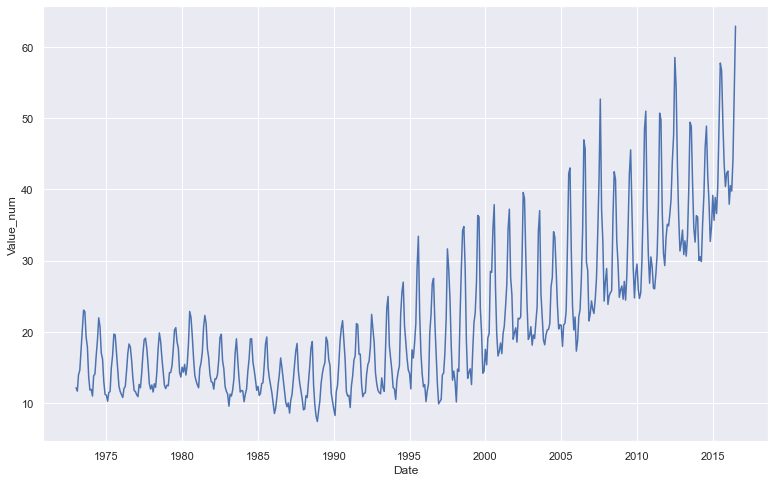

In [15]:
sns.set(rc={'figure.figsize':(13,8)})
sns.lineplot(data = dff, x ="Date", y = 'Value_num')

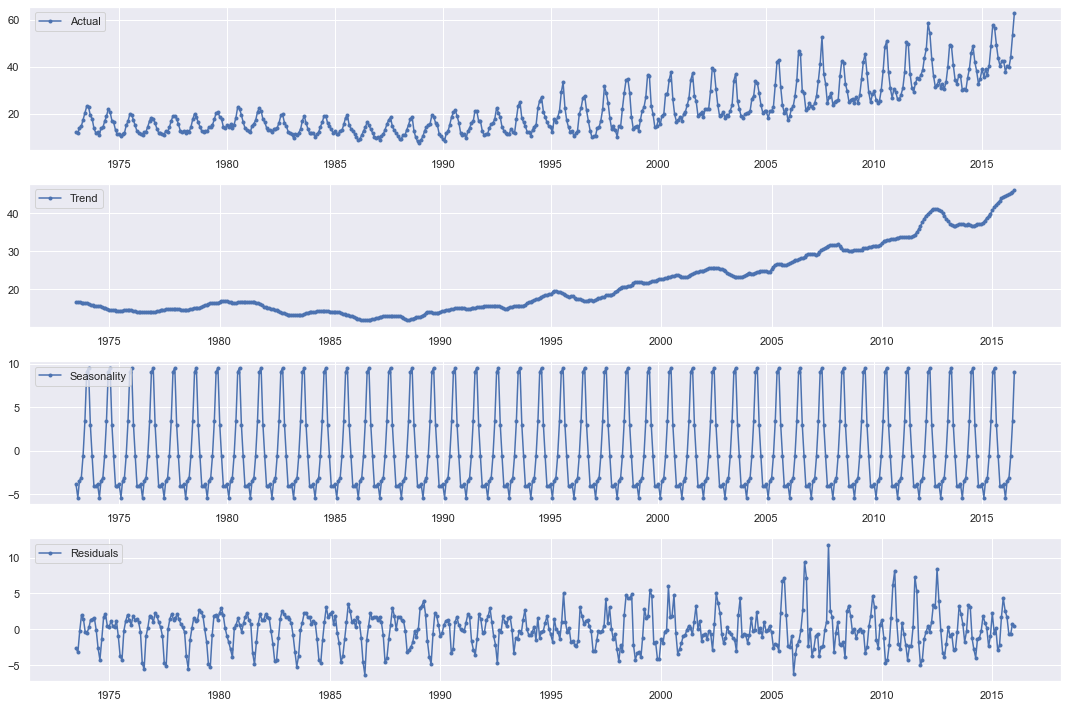

In [16]:
#Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(dff)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(dff, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

In [17]:
# Splitting the data into train and test (24 months for test data set)
df_train, df_test = dff[dff.index< '2014-8-1'], dff[dff.index >= '2014-8-1']
print(df_train.shape)
print(df_test.shape)

(499, 1)
(24, 1)


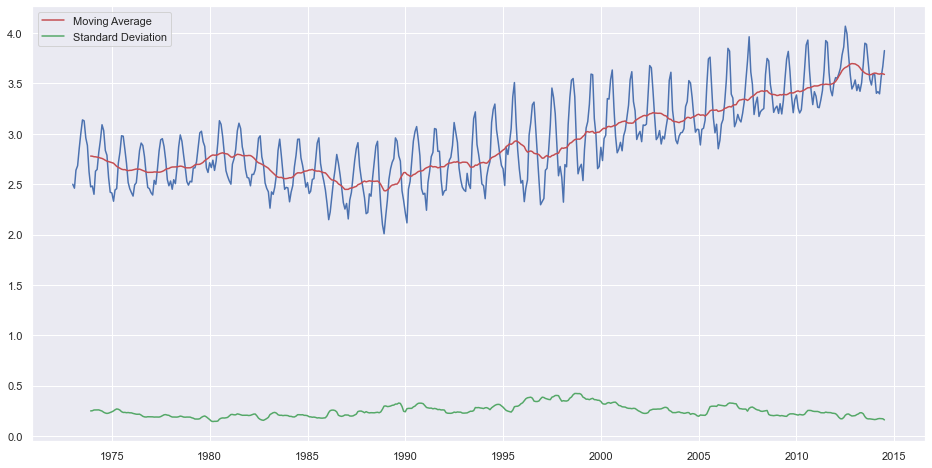

In [18]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

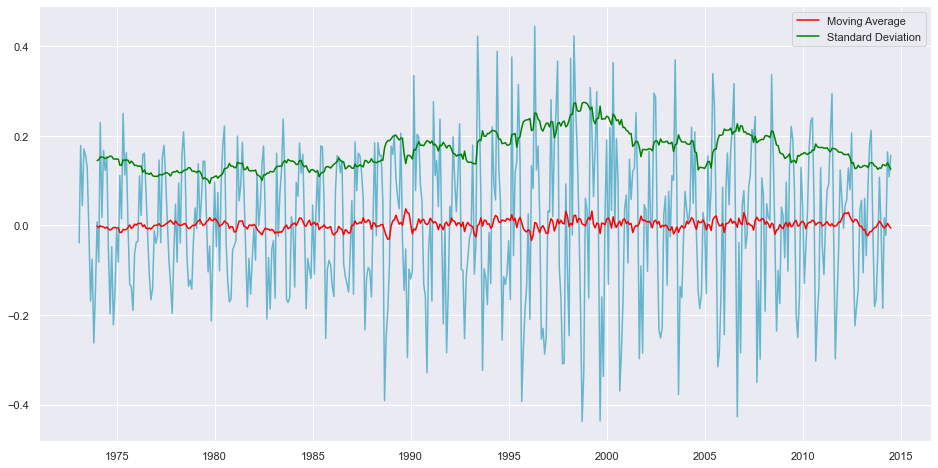

In [19]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

In [20]:
# Let's confirm stationarity of residual values with adfuller test
def adfuller(data):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller

  print('Dickey-Fuller Test: ')
  adftest = adfuller(data)
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)

adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -4.951428
p-value                   0.000028
Lags Used                18.000000
No. of Observations     479.000000
Critical Value (1%)      -3.444076
Critical Value (5%)      -2.867593
Critical Value (10%)     -2.569994
dtype: float64


**Observation**

- From the above test, we can see that the p-value is very close to 0, much smaller than 0.05, therefore, we reject the null hypothesis and confirmed that the residual values are stationary**

<Figure size 1152x576 with 0 Axes>

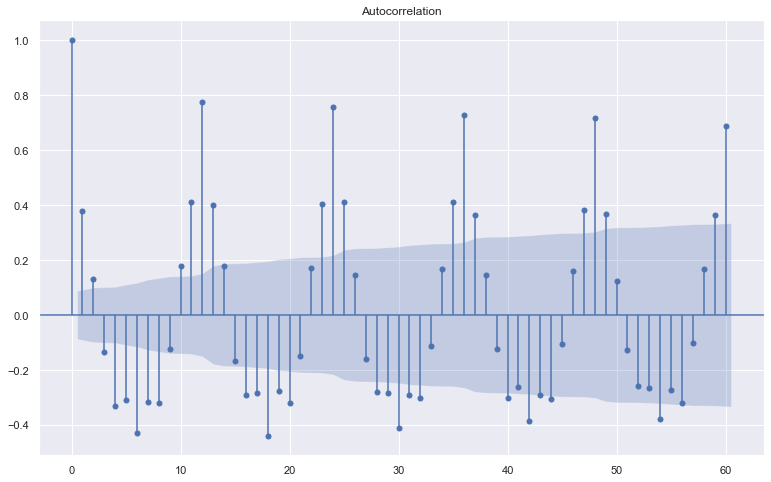

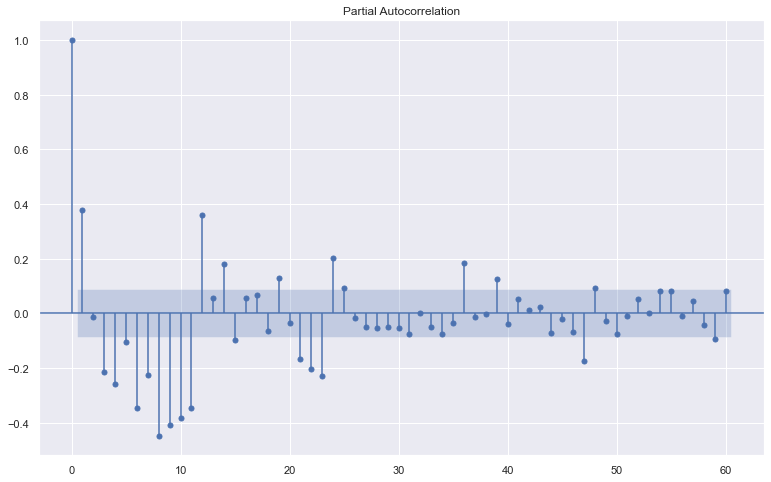

In [21]:
# Let's now plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 60) 
plt.show()
plot_pacf(df_shift, lags = 60) 
plt.show()

**Observation**

- To interpret these plots, I refered to 'ACF/PACF Plot' cheatsheet which I found in the below link

    - https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali/

- Although not quite, the cheatsheet suggests that the plots indicate our data behaves similar to Seasonal ARIMA(SARIMA) model with an AR(1) component as I could find the below patterns from the plots
    - ACF : Geometric Decay at each 12 lag
    - PACF : Significant at each 12 lag

- As for p and q values, they will be decided on my next step below

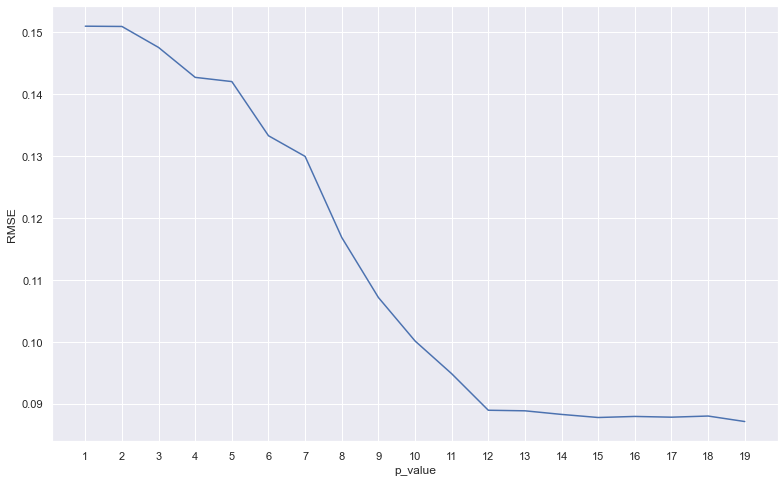

In [23]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

def Plot_AR_rmse_over_p(df):

    rmse_over_p = []
    pvalue = []

    for n in np.arange(1,20):
        model_AR = AutoReg(df, lags=n) 
        results_AR = model_AR.fit() 
        predict = results_AR.predict(start=0,end=len(df)-1) 
        predict = predict.fillna(0) 
        rmse = mean_squared_error(predict,df['Value_num'], squared=False)
        rmse_over_p.append(rmse)
        pvalue.append(n)
        
    dfrmse = pd.DataFrame(rmse_over_p, columns = ['RMSE'])
    dfrmse['p_value'] = pvalue
    sns.lineplot(x=dfrmse.p_value, y=dfrmse.RMSE)
    plt.xticks(np.arange(1,20))
    
Plot_AR_rmse_over_p(df_shift)

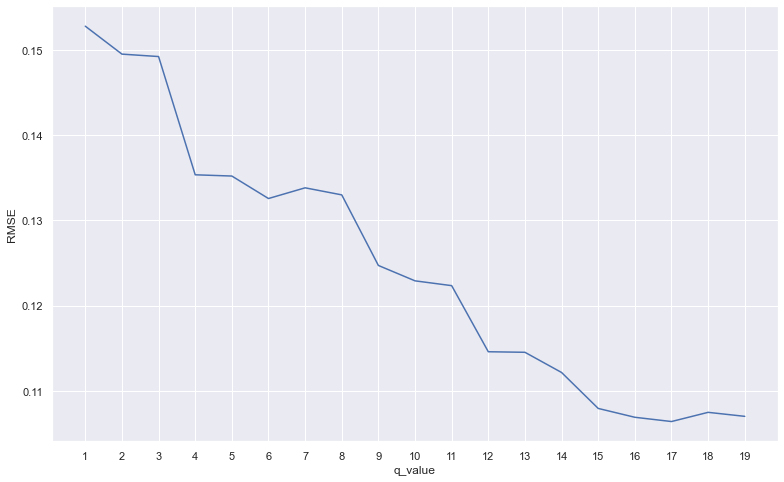

In [24]:
def Plot_MA_rmse_over_p(df):

    rmse_over_q = []
    qvalue = []

    for n in np.arange(1,20):
        model_MA = ARIMA(df_shift, order=(0, 0, n)) 
        results_MA = model_MA.fit()
        rmse_over_q.append(mean_squared_error(results_MA.fittedvalues,df_shift['Value_num'], squared=False))
        qvalue.append(n)
        
    dfrmse = pd.DataFrame(rmse_over_q, columns = ['RMSE'])
    dfrmse['q_value'] = qvalue
    sns.lineplot(x=dfrmse.q_value, y=dfrmse.RMSE)
    plt.xticks(np.arange(1,20))

Plot_MA_rmse_over_p(df_shift)

In [25]:
#setting up a list that will store test results
results = []

<h1>AR Model</h1>

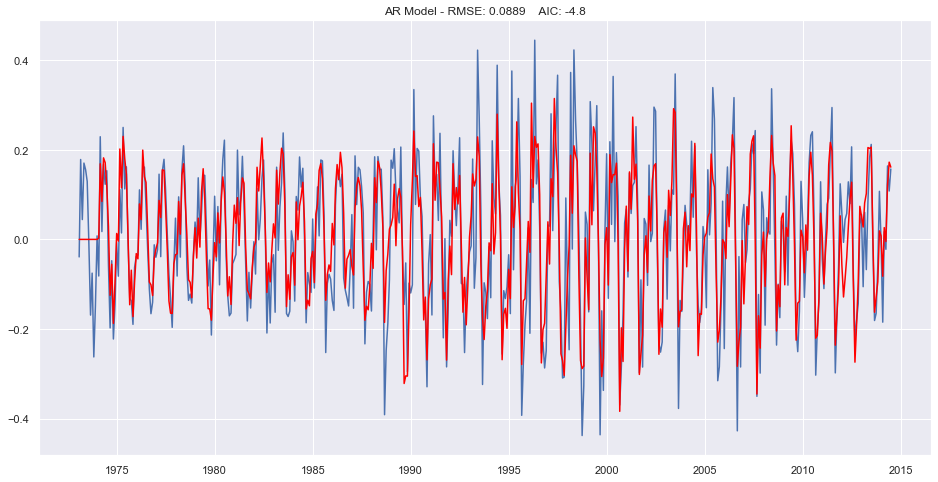

In [26]:
plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=12)
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
rmse = mean_squared_error(predict,df_shift['Value_num'], squared=False)
aic = results_AR.aic
dic = {'Model': 'AR', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('AR Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic )  #Calculating rmse
plt.show()


<h1>MA Model</h1>

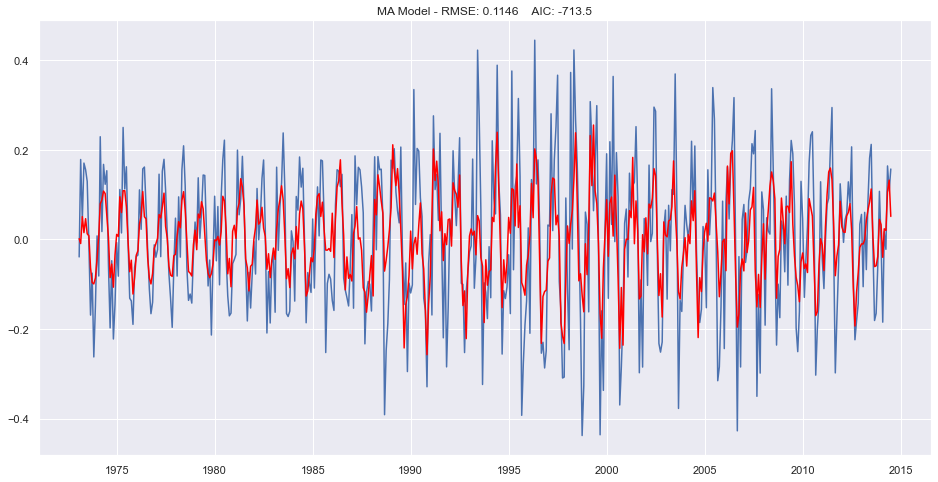

In [27]:
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 12)) 
results_MA = model_MA.fit()
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
rmse = mean_squared_error(results_MA.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_MA.aic
dic = {'Model': 'MA', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('MA Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic )  
plt.show()

<h1>ARMA</h1>

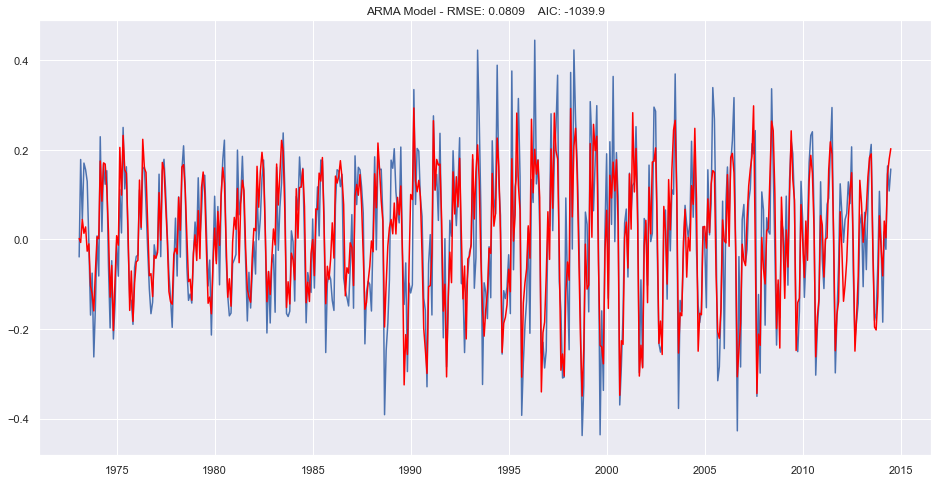

In [28]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(12, 0, 12)) 
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
rmse = mean_squared_error(results_ARMA.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_ARMA.aic
dic = {'Model': 'ARMA', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('ARMA Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

<h1>ARIMA d=1</h1>

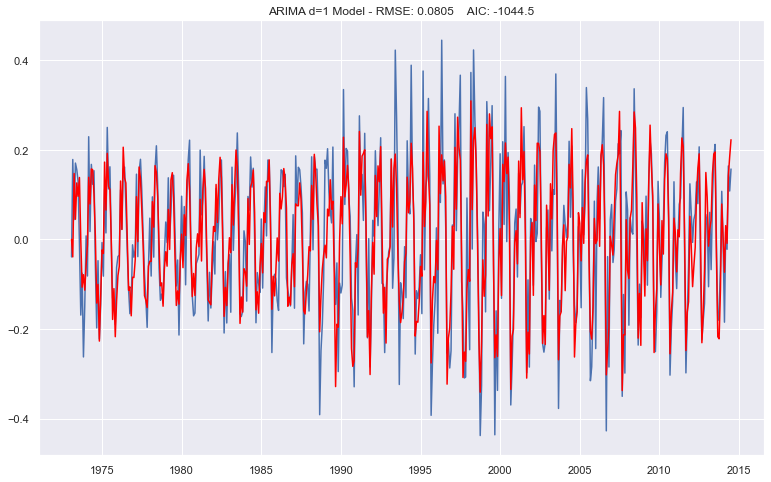

In [29]:
model_ARIMA = ARIMA(df_shift, order=(12, 1, 12)) 
results_ARIMA = model_ARIMA.fit()
plt.plot(df_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
rmse = mean_squared_error(results_ARIMA.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_ARIMA.aic
dic = {'Model': 'ARIMA d=1', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('ARIMA d=1 Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

<h1>ARIMA d=2</h1>

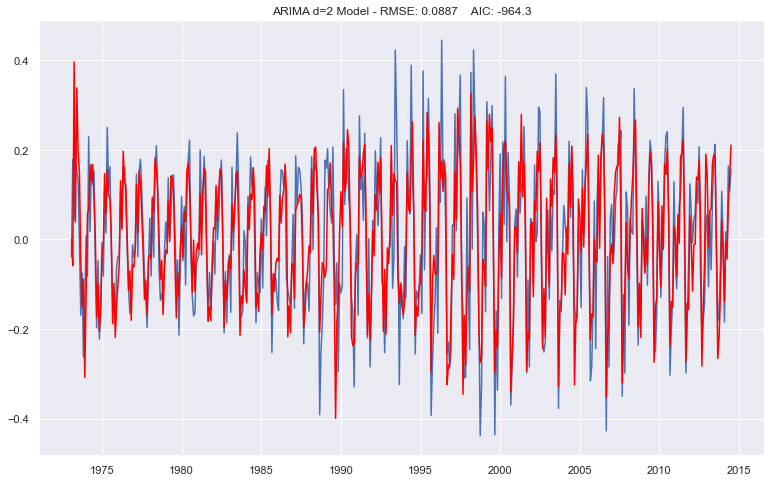

In [30]:
model_ARIMA2 = ARIMA(df_shift, order=(12, 2, 12)) 
results_ARIMA2 = model_ARIMA2.fit()
plt.plot(df_shift)
plt.plot(results_ARIMA2.fittedvalues, color='red')
rmse = mean_squared_error(results_ARIMA2.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_ARIMA2.aic
dic = {'Model': 'ARIMA d=2', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('ARIMA d=2 Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

<h1>SARIMAX</h1>

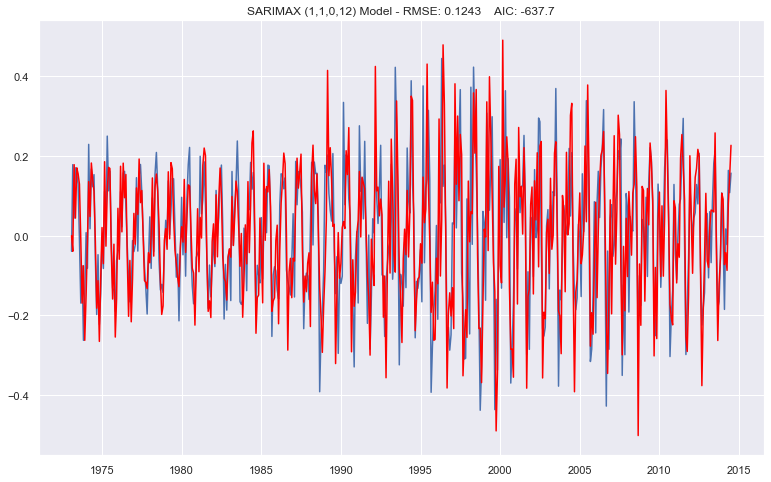

In [31]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_shift['Value_num'],order=(1, 1, 0),seasonal_order=(1,1,0,12))
results_SARIMAX =model.fit()
plt.plot(df_shift)
plt.plot(results_SARIMAX.fittedvalues, color='red')
rmse = mean_squared_error(results_SARIMAX.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_SARIMAX.aic
dic = {'Model': 'SARIMAX (1,1,0,12)', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('SARIMAX (1,1,0,12) Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

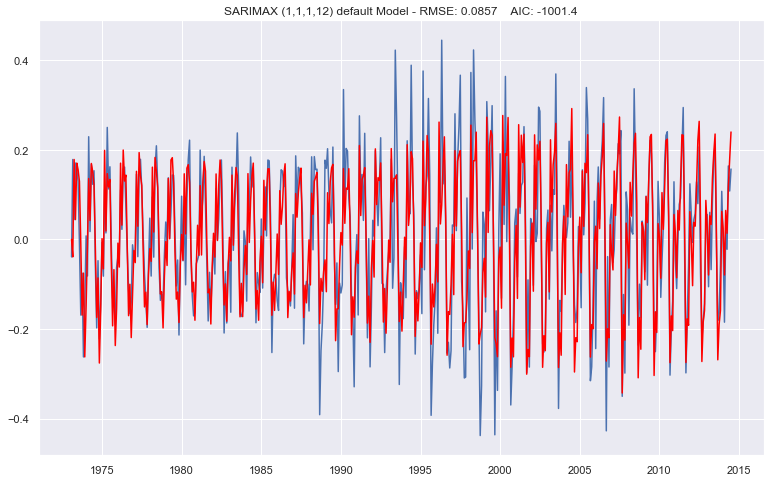

In [32]:
model2=sm.tsa.statespace.SARIMAX(df_shift['Value_num'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_SARIMAX2 =model2.fit()
plt.plot(df_shift)
plt.plot(results_SARIMAX2.fittedvalues, color='red')
rmse = mean_squared_error(results_SARIMAX2.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_SARIMAX2.aic
dic = {'Model': 'SARIMAX (1,1,1,12)', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('SARIMAX (1,1,1,12) default Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

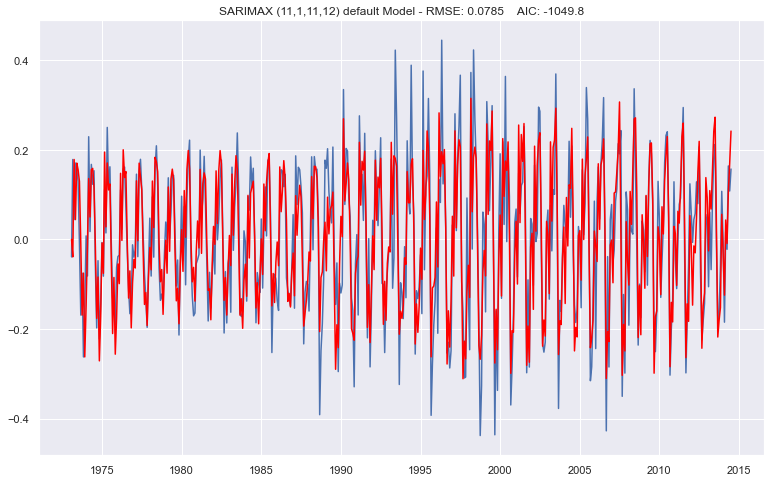

In [33]:
model3=sm.tsa.statespace.SARIMAX(df_shift['Value_num'],order=(11, 1, 11),seasonal_order=(1,1,1,12))
results_SARIMAX3 =model3.fit()
plt.plot(df_shift)
plt.plot(results_SARIMAX3.fittedvalues, color='red')
rmse = mean_squared_error(results_SARIMAX3.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_SARIMAX3.aic
dic = {'Model': 'SARIMAX (11,1,11,12)', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('SARIMAX (11,1,11,12) default Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

In [34]:
df_result =  pd.DataFrame(results)
df_result

,Model,RMSE,AIC
0,AR,0.0889,-4.8
1,MA,0.1146,-713.5
2,ARMA,0.0809,-1039.9
3,ARIMA d=1,0.0805,-1044.5
4,ARIMA d=2,0.0887,-964.3
5,"SARIMAX (1,1,0,12)",0.1243,-637.7
6,"SARIMAX (1,1,1,12)",0.0857,-1001.4
7,"SARIMAX (11,1,11,12)",0.0785,-1049.8


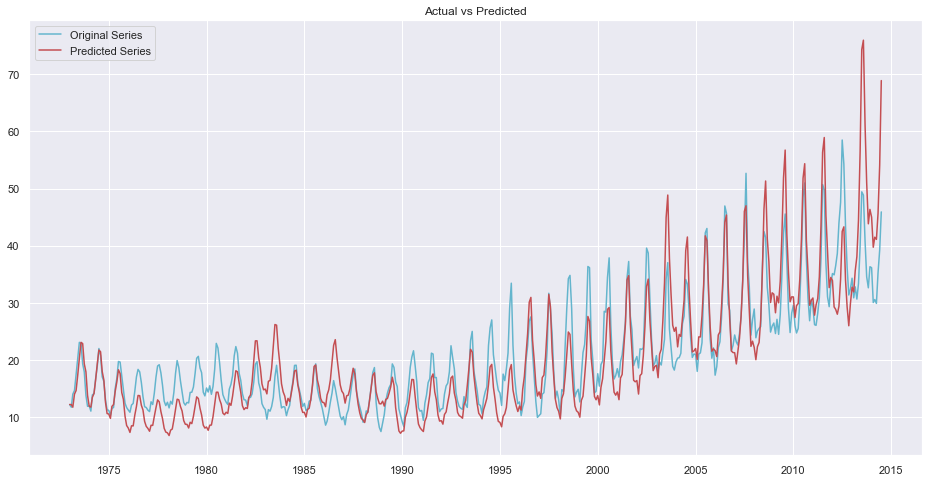

In [35]:
predictions=results_SARIMAX3.fittedvalues
predictions_cumsum = predictions.cumsum()
predictions_log = pd.Series(df_log['Value_num'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_SARIMAX3 = np.exp(predictions_log)

plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')
plt.plot(predictions_SARIMAX3, color = 'r', label = 'Predicted Series')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

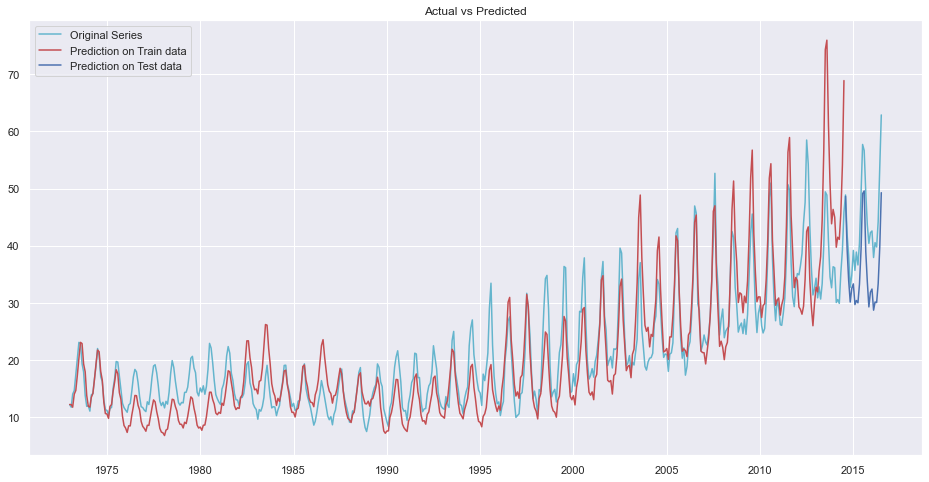

In [36]:
forecasted_SARIMAX3 = results_SARIMAX3.forecast(steps=24) 
forecasted_cumsum = forecasted_SARIMAX3.cumsum()
index = df_test.index
df1 = pd.DataFrame()
df1['cumsum'] = forecasted_cumsum
df1.index = index
df1['Forecasted'] = df1['cumsum'] + float(df_log.loc['2014-07-01'])
forecasted_SARIMAX3 = np.exp(df1['Forecasted'])

plt.figure(figsize=(16,8))
plt.plot(dff, color = 'c', label = 'Original Series')
plt.plot(predictions_SARIMAX3, color = 'r', label = 'Prediction on Train data')
plt.plot(forecasted_SARIMAX3, label = 'Prediction on Test data', color='b')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(predictions_SARIMAX3, df_train, squared = False)
test_error = mean_squared_error(forecasted_SARIMAX3, df_test, squared = False)
print("MSE on Train Dataset : ",np.round(train_error,2))
print("MSE on Test Dataset : ",np.round(test_error,2))

MSE on Train Dataset :  5.21
MSE on Test Dataset :  8.7


In [39]:
df

,MSN,YYYYMM,Value,Description,Date,Value_num,Fuel Type
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions,1973-01-01,72.076,Coal
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions,1973-02-01,64.442,Coal
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions,1973-03-01,64.084,Coal
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions,1973-04-01,60.842,Coal
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions,1973-05-01,61.798,Coal
...,...,...,...,...,...,...,...
5089,TXEIEUS,201603,115.997,Total Energy Electric Power Sector CO2 Emissions,2016-03-01,115.997,Total
5090,TXEIEUS,201604,113.815,Total Energy Electric Power Sector CO2 Emissions,2016-04-01,113.815,Total
5091,TXEIEUS,201605,129.44,Total Energy Electric Power Sector CO2 Emissions,2016-05-01,129.440,Total
5092,TXEIEUS,201606,172.074,Total Energy Electric Power Sector CO2 Emissions,2016-06-01,172.074,Total


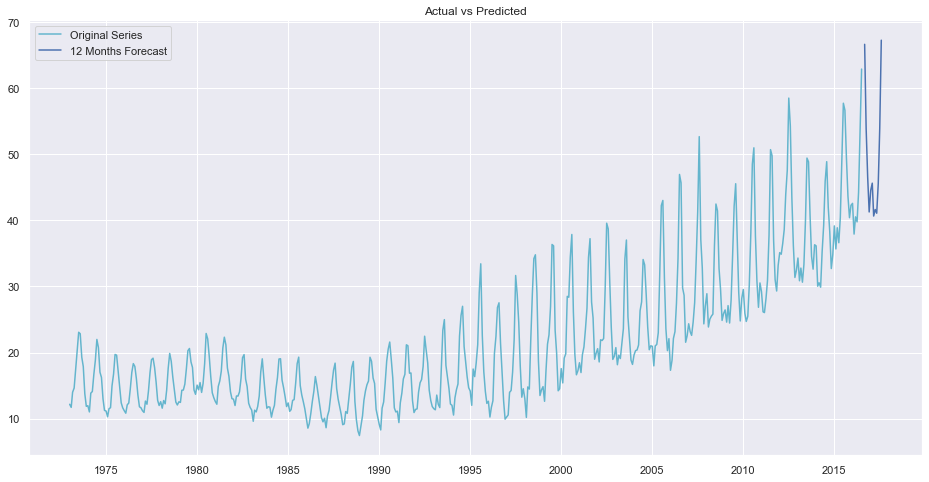

In [59]:
forecasted_SARIMAX3 = results_SARIMAX3.forecast(steps=12)
forecasted_cumsum = forecasted_SARIMAX3.cumsum()

index = pd.date_range('2016-08-01','2017-08-01' , freq='1M')
dft = pd.DataFrame()
dft['cumsum'] = forecasted_cumsum
dft.index = index

dft['Forecasted'] = dft['cumsum'] + float(np.log(dff).loc['2016-07-01'])
forecasted_SARIMAX3 = np.exp(dft['Forecasted'])

plt.figure(figsize=(16,8))
plt.plot(dff, color = 'c', label = 'Original Series')
plt.plot(forecasted_SARIMAX3, label = '12 Months Forecast', color='b')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()